In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler,Estimator
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient,ParamShiftSamplerGradient
from qiskit.circuit import ParameterVector
%matplotlib inline


/var/folders/9v/dz00k5396wl369lhxwggy12m0000gn/T/ipykernel_3598/69454660.py:9: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.gradients import ParamShiftEstimatorGradient,ParamShiftSamplerGradient


In [2]:
from VQS_header import compute_params_list,compute_magnetization

In [33]:
num_qubits = 3
j_coupling = 1/4
h_coupling = 1

num_layers = 3
time_max = 5e0
epsilon_det = 1e-7
num_steps = 100
sampler = Sampler()
estimator = Estimator()
nShots=None

dt=time_max/num_steps
sampler=Sampler()

print("dt = ",dt)

dt =  0.05


In [39]:
def addSuzukiTrotter(circuit,j,h,dt):
    num_qubits=circuit.num_qubits
    #Implementing Suzuki-Trotter evolution step for the transverse Ising
    for i in range(num_qubits):
        circuit.rx(-2*h*dt,i)
    
    for i in range(num_qubits-1):
        circuit.rzz(-2*j*dt,i,i+1)
    return circuit

def getAnsatz(num_qubits,n_layers=3,weight_name="weight"):
    n_params=n_layers*(2*num_qubits-1)
    ansatz = QuantumCircuit(num_qubits,num_qubits) 
    weights = ParameterVector(weight_name, n_params)
    params_index=0
    for layer in range(num_layers):
        for i in range(num_qubits):
            ansatz.rx(weights[params_index],i)
            params_index+=1
        for i in range(num_qubits-1):
            ansatz.rzz(weights[params_index],i,i+1)
            params_index+=1
            
    return ansatz
    

def getCircuit(num_qubits,n_layers=3,j=j_coupling,h=h_coupling,dt=dt):
    circuit = QuantumCircuit(num_qubits,num_qubits) 
    
    ansatz = getAnsatz(num_qubits,n_layers=n_layers)
    ansatz_inv = getAnsatz(num_qubits,n_layers=n_layers,weight_name="weight_inverse").inverse()
    
    circuit.compose(ansatz_inv, inplace=True)
    circuit.barrier()
    addSuzukiTrotter(circuit,j,h,dt)
    circuit.barrier()
    circuit.compose(ansatz, inplace=True)  
    
    circuit.measure(circuit.qubits,circuit.clbits)
    return circuit

In [40]:
qc = getCircuit(num_qubits,n_layers=num_layers)

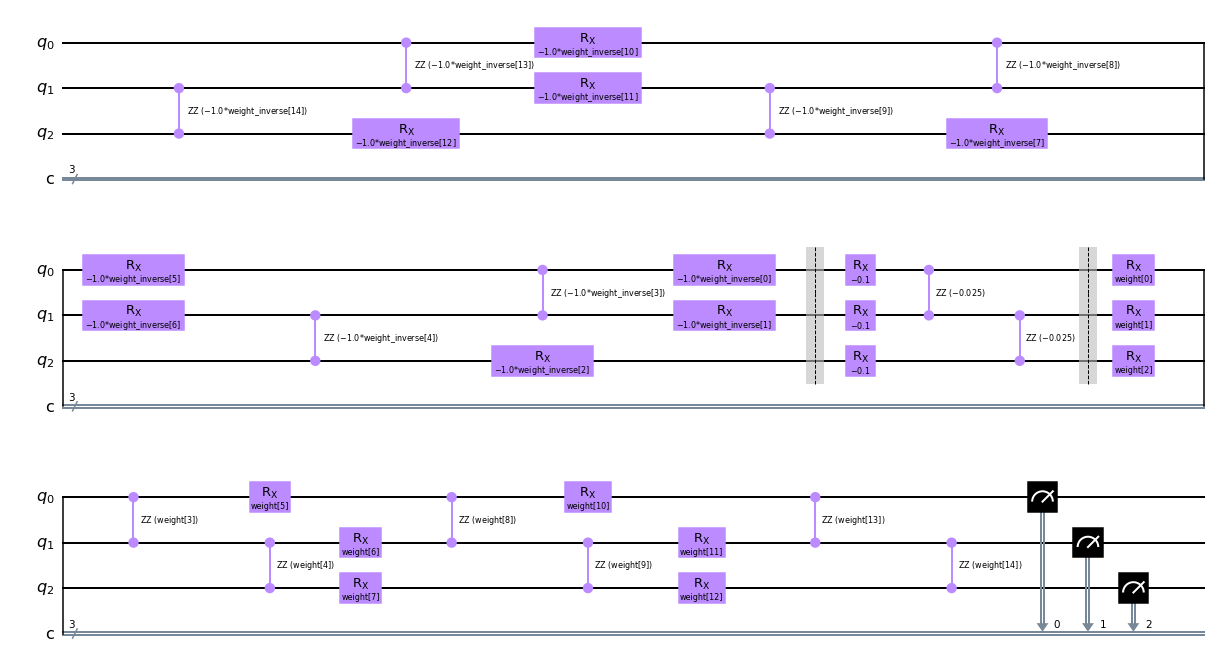

In [41]:
qc.draw('mpl')

In [37]:
def paramShift(weights,sampler=sampler):
    weights_list=[weights]
    for i in range(n_params_ansatz):
        weightsPlus=weights.copy()
        weightsPlus[i]+=np.pi/2
        weights_list.append(weightsPlus)

        weightsMinus=weights.copy()
        weightsMinus[i]-=np.pi/2
        weights_list.append(weightsMinus)

    results=sampler.run(circuits=[qc]*len(weights_list),parameter_values=weights_list).result().quasi_dists
    output=results[0][0]
    
    grad_list=[]
    for i in range(n_params_ansatz):
        tmpGrad_output=0.5*(results[2*i+1][0] - results[2*i+2][0])
        tmpGrad = -(2*(1-output)/(dt**2))*tmpGrad_output
        grad_list.append(tmpGrad)
    loss=((1-output)**2)/(dt**2)
    return loss,np.array(grad_list)

In [38]:
print("dt = ",dt)
learning_rate=1e-1
nIterations=20
n_params_ansatz=int(qc.num_parameters/2)
#Preparing weights, starting with same weights for both ansatz and its inverse
weights_init=np.random.rand(n_params_ansatz)
weights_init=np.concatenate([weights_init,weights_init])
weights=weights_init


for Iter in range(nIterations):
    
    for step in range(50):
        loss,grad_list=paramShift(weights,sampler=sampler)
        weights[0:n_params_ansatz]-=learning_rate*grad_list
        if step==0:
            print("initial loss = ",loss)
        if loss<1e-5:
            print(i,loss)
            print(weights)
            print('----')
            weights[n_params_ansatz:]=weights[0:n_params_ansatz]
            break


dt =  0.05
initial loss =  0.02217421688701408
8 9.644139407078056e-06
[0.95365976 0.31532962 0.58827606 0.10549958 0.26588601 0.91010569
 0.80127743 0.8724041  0.11782297 0.10544149 0.14121279 0.31704119
 0.29849567 0.89115314 0.68661155 0.92301863 0.28642889 0.55929413
 0.10029508 0.26167841 0.879009   0.77190567 0.84186903 0.11899793
 0.10553925 0.10980062 0.28785427 0.2673328  0.89115314 0.68661155]
----
initial loss =  0.02215122206796797
8 9.963336865334255e-06
[0.98426436 0.34421256 0.6171913  0.1104721  0.27030186 0.94114129
 0.83050298 0.90285285 0.11656115 0.10546716 0.17254036 0.34611369
 0.32959762 0.89115314 0.68661155 0.95365976 0.31532962 0.58827606
 0.10549958 0.26588601 0.91010569 0.80127743 0.8724041  0.11782297
 0.10544149 0.14121279 0.31704119 0.29849567 0.89115314 0.68661155]
----
initial loss =  0.022130209888433793
8 9.822503271821292e-06
[1.01487895 0.37316622 0.64610092 0.11520729 0.27492255 0.97216101
 0.85964493 0.93326993 0.11521961 0.10565019 0.20383662 0.3